__<h1>ADA_BOOST & RANDOM FOREST</h1>__

___KEY NOTES IN VERSION 3___
- in this notebook, we aim to determine if the home team wins, 1, or doesn't 0. (loss or draw)
- I used the random forest and adaptive boosting models using their default parameters
- performance evaluated with k-fold cv
- outliers removed

In [1]:
import pandas as pd, numpy as np, seaborn as sns, glob, time, os, matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
os.chdir('/Users/ERIA/Desktop/MATCH_DATA/')

The cell below shows how the glob module is used to gather file names of the same type into a list. In this case, I collected all csv files in the /Users/ERIA/Desktop/MATCH_DATA/ directory

In [3]:
csv_files=glob.glob('*.csv')
len(csv_files)

7

all the files are then concatanated together along the rows (axis=0) to form one collection df

In [4]:
count=0
for file in tqdm(csv_files):
    
    if count ==0:
        df=pd.read_csv(file)
        count+=1
        continue
    else:
        file=pd.read_csv(file)
        df=pd.concat([df,file], axis=0)
        count+=1
df.shape

100%|██████████| 7/7 [00:00<00:00, 86.64it/s]


(3233, 8)

__<h2>DATA CLEANING</h2>__

In [5]:
df.head()

,Unnamed: 0,hm_team,aw_team,hm_odd,dw_odd,aw_odd,hm_sco,aw_sco
0,0,Paris SG,Brest,1.09,13.70,26.00,1,0
1,1,Marseille,Lille,2.05,3.66,3.68,2,1
2,2,Bayern Munich,Stuttgart,1.23,6.79,13.30,2,2
3,3,Eintracht Frankfurt,Wolfsburg,1.89,3.83,4.13,0,1
4,4,Hertha Berlin,Bayer Leverkusen,4.07,3.88,1.89,2,2


In [6]:
df.drop(columns=['Unnamed: 0'],inplace=True, axis=1)
df.head()

,hm_team,aw_team,hm_odd,dw_odd,aw_odd,hm_sco,aw_sco
0,Paris SG,Brest,1.09,13.70,26.00,1,0
1,Marseille,Lille,2.05,3.66,3.68,2,1
2,Bayern Munich,Stuttgart,1.23,6.79,13.30,2,2
3,Eintracht Frankfurt,Wolfsburg,1.89,3.83,4.13,0,1
4,Hertha Berlin,Bayer Leverkusen,4.07,3.88,1.89,2,2


In [7]:
df.isna().sum()

hm_team    0
aw_team    0
hm_odd     0
dw_odd     0
aw_odd     0
hm_sco     0
aw_sco     0
dtype: int64

In [8]:
df.dropna(inplace=True)
df.isna().sum()

hm_team    0
aw_team    0
hm_odd     0
dw_odd     0
aw_odd     0
hm_sco     0
aw_sco     0
dtype: int64

In [9]:
df.dtypes

hm_team    object
aw_team    object
hm_odd     object
dw_odd     object
aw_odd     object
hm_sco     object
aw_sco     object
dtype: object

The data contains hyphens '-' for matches that didn't have odds by the time of collection. These records have to be dropped. I replace hyphens with nulls which I subsquently drop too as shown below 

In [10]:
df.replace(to_replace='-', value=np.nan, inplace=True)
df.isna().sum()

hm_team      0
aw_team      0
hm_odd     770
dw_odd     769
aw_odd     769
hm_sco       0
aw_sco       2
dtype: int64

In [11]:
df.dropna(inplace=True)
df.isna().sum()

hm_team    0
aw_team    0
hm_odd     0
dw_odd     0
aw_odd     0
hm_sco     0
aw_sco     0
dtype: int64

In [14]:
df.drop(columns=['hm_team','aw_team'],inplace=True, axis=1)

All features converted to float

In [15]:
df=df.astype('float')
df.dtypes

hm_odd    float64
dw_odd    float64
aw_odd    float64
hm_sco    float64
aw_sco    float64
dtype: object

In [16]:
df.head()

,hm_odd,dw_odd,aw_odd,hm_sco,aw_sco
0,1.09,13.70,26.00,1.0,0.0
1,2.05,3.66,3.68,2.0,1.0
2,1.23,6.79,13.30,2.0,2.0
3,1.89,3.83,4.13,0.0,1.0
4,4.07,3.88,1.89,2.0,2.0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2463 entries, 0 to 217
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   hm_odd  2463 non-null   float64
 1   dw_odd  2463 non-null   float64
 2   aw_odd  2463 non-null   float64
 3   hm_sco  2463 non-null   float64
 4   aw_sco  2463 non-null   float64
dtypes: float64(5)
memory usage: 115.5 KB


__<h3>creating the target variable, result</h3>__
for the home team win, we classify that as 1. A draw or win for the away team, 0

In [18]:
#aiming
df['result']=np.where(df['hm_sco']==df['aw_sco'],0, np.where(df.hm_sco<df.aw_sco,0,1) )

df.head()

,hm_odd,dw_odd,aw_odd,hm_sco,aw_sco,result
0,1.09,13.70,26.00,1.0,0.0,1
1,2.05,3.66,3.68,2.0,1.0,1
2,1.23,6.79,13.30,2.0,2.0,0
3,1.89,3.83,4.13,0.0,1.0,0
4,4.07,3.88,1.89,2.0,2.0,0


In [19]:
df.result.value_counts()

0    1379
1    1084
Name: result, dtype: int64

In [20]:
df.shape

(2463, 6)

In [21]:
df.drop(columns=['hm_sco','aw_sco'], inplace=True)
df.head()

,hm_odd,dw_odd,aw_odd,result
0,1.09,13.70,26.00,1
1,2.05,3.66,3.68,1
2,1.23,6.79,13.30,0
3,1.89,3.83,4.13,0
4,4.07,3.88,1.89,0


__<h3>Dealing with Duplicates</h3>__

In [22]:
duplicates=df[df.duplicated()==True]
duplicates.to_csv('/Users/ERIA/Desktop/MATCH_DATA/COMPILED_MATCH_DATA/duplicates.csv')

In [23]:
df[df.duplicated()==True].shape

(51, 4)

In [24]:
df.drop_duplicates(inplace=True)

In [25]:
df.shape

(2412, 4)

In [26]:
df.to_csv('/Users/ERIA/Desktop/MATCH_DATA/COMPILED_MATCH_DATA/compiled_data.csv')

__<h3>OUTLIER DETECTION & REMOVAL</h3>__

<AxesSubplot:>

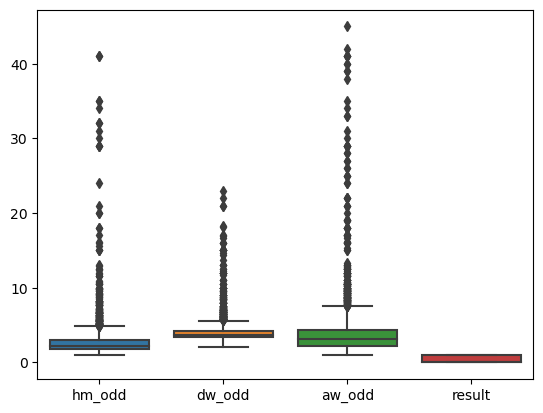

In [27]:
sns.boxplot(data=df)

__<h4>Removal of Outliers</h4>__

<AxesSubplot:>

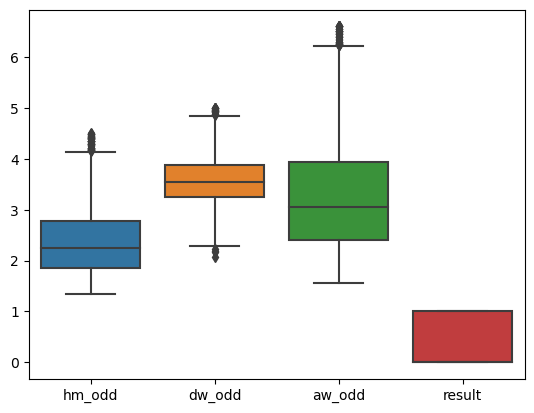

In [31]:
df.hm_odd=np.where(df.hm_odd>4.5,np.nan, df.hm_odd)
df.dw_odd=np.where(df.dw_odd>5,np.nan, df.dw_odd)
df.aw_odd=np.where(df.aw_odd>6.6,np.nan, df.aw_odd)
df2=df.dropna()
df=df2
sns.boxplot(data=df2)

In [42]:
df.result.value_counts()

0    1078
1     799
Name: result, dtype: int64

<h2>MODEL DEVELOPMENT</h2>

__<h2>RANDOM FOREST</h2>__

In [78]:
from sklearn.model_selection import train_test_split

X=df.drop('result', axis=1)
y=df['result']

col_names=X.columns

x_train, x_test, y_train, y_test=train_test_split(X,y,test_size=0.3)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
model_rf=RandomForestClassifier(n_jobs=-1,)

model_rf.fit(x_train,y_train)

y_pred=model_rf.predict(x_test)

print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.5886524822695035
              precision    recall  f1-score   support

           0       0.66      0.66      0.66       340
           1       0.48      0.48      0.48       224

    accuracy                           0.59       564
   macro avg       0.57      0.57      0.57       564
weighted avg       0.59      0.59      0.59       564



__<h3>CROSS VALIDATION ON THE RANDOM FOREST MODEL</h3>__
The purpose is to see how the model performs on unseen data

In [33]:
from sklearn.model_selection import cross_val_score
accuracies=cross_val_score(estimator=model_rf, X=x_train, y=y_train, cv=10, n_jobs=-1)
accuracies

array([0.59090909, 0.61363636, 0.56818182, 0.50381679, 0.57251908,
       0.54961832, 0.52671756, 0.57251908, 0.52671756, 0.58015267])

__<h2>ADA_BOOST</h2>__

In [34]:
from sklearn.ensemble import AdaBoostClassifier

model_ada=AdaBoostClassifier(base_estimator=model_rf, n_estimators=100, 
                             learning_rate=0.5, random_state=91)

model_ada.fit(x_train,y_train)
y_pred=model_ada.predict(x_test)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.5886524822695035
              precision    recall  f1-score   support

           0       0.65      0.68      0.66       337
           1       0.49      0.45      0.47       227

    accuracy                           0.59       564
   macro avg       0.57      0.57      0.57       564
weighted avg       0.58      0.59      0.59       564



__<h3>CROSS VALIDATION ON THE ADAPTIVE BOOSTING MODEL</h3>__
The purpose is to see how the model performs on unseen data

__<h3>TESTING BOTH MODELS ON NEW DATA</h3>__

In [81]:
df2=pd.read_csv('/Users/ERIA/Desktop/test_data3.csv')
#df2.dropna(inplace=True)
#df2.result=df2['result'].astype('int')
x_test2=df2.iloc[:,:3].astype('float')
df2

,home,draw,away,result
0,2.45,3.30,2.79,0
1,2.44,3.34,2.77,0
2,2.32,3.63,3.03,0
3,2.47,3.33,2.74,0


In [82]:
y_pred2=model_rf.predict(x_test2)
print('actual_values ---> ',list(np.array(df2.result)))
print('predicted_values ->',list(y_pred2))

actual_values --->  [0, 0, 0, 0]
predicted_values -> [0, 0, 1, 0]


In [83]:
y_pred2=model_ada.predict(x_test2)
print('actual_values ---> ',list(np.array(df2.result)))
print('predicted_values ->',list(y_pred2))

actual_values --->  [0, 0, 0, 0]
predicted_values -> [0, 1, 0, 0]
